## Welcome to the notebook!

To run the system on an audio file of your choice, please run the 'Prerequisites' section before selecting a piece of music in first cell of the 'Image Processing' section. All other sections are for training the models used by the system and do not need to be run.

###Prerequisites

In [1]:
!pip install timbral_models

# General
import numpy as np
import os
import random
from matplotlib import pyplot as plt
import IPython.display as ipd
from ipywidgets import IntProgress

# Audio processing
import timbral_models
import librosa
from librosa import beat, onset, feature, effects
from librosa.display import specshow

# Image processing
from PIL import Image, ImageOps, ImageEnhance, ImageFilter
import cv2
import moviepy.editor as mp
from google.colab.patches import cv2_imshow
from base64 import b64encode

# Stuff for TensorFlow
import tensorflow as tf
import tensorflow.keras
import keras
from tensorflow.keras import datasets, layers, models

# Stuff for colour CNN
import xml.etree.ElementTree as ET
import colorsys

%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 59 kB 4.6 MB/s 
  Created wheel for timbral-models: filename=timbral_models-0.4.0-py3-none-any.whl size=68071 sha256=cdf97254c6f277de893f6502030d2b62e0cdda2977ee6b66ee88c492a2937c10
  Stored in directory: /root/.cache/pip/wheels/16/28/0d/89d6cb4da30ecf8a9b4b475ba9b26fe3401c295bf6f113e092
Successfully built timbral-models
Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1941504/45929032 bytes (4.2%)3842048/45929032 bytes (8.4%)6037504/45929032 bytes (13.1%)7823360/45929032 bytes (17.0%)9789440/45929032 bytes (21.3%)11673600/45929032 bytes (25.4%)13934592/45929

In [2]:
# File locations

# Shapes cGAN (using the datasets from the second study)
sketch_loc = '/content/drive/MyDrive/CC/Datasets/Sketches2'
sound_loc = "/content/drive/MyDrive/CC/Datasets/Sounds2"

# Colours CNN
moodo_audio_loc = '/content/drive/MyDrive/CC/Datasets/moodo_dataset/audio'
moodo_xml_loc = '/content/drive/MyDrive/CC/Datasets/moodo_dataset/dataset.xml'

# Image Processing
audio_loc = '/content/drive/MyDrive/CC/Music/'
video_path = '/content/drive/MyDrive/CC/Outputs'

# Trained model locations
colour_model_loc = '/content/drive/MyDrive/CC/Models/colour_model'
shapes_model_loc = '/content/drive/MyDrive/CC/Models/shape_model'

In [3]:
# Global variables

# Number of bins to use in the Mel spectrograms
no_bins = 192
# Number of features in timbre vector representation
num_audio_features = 7
# Image width/height for shapes GAN
image_size = 56

In [4]:
# Functions used across the notebook

def signal_to_spectrogram(signal, Fs):
  """
  Function to extract a dB/Mel-scaled spectrogram from an audio signal
  
  Arguments:
  signal - signal to be filtered
  Fs - sampling rate

  Returns:
  spectrum - the spectrum array
  """
  
  # get mel spectrogram
  spectrum = np.array(librosa.feature.melspectrogram(signal, Fs, hop_length=512, n_mels=no_bins))
  # take magnitude of spectrogram and apply decibel scale
  spectrum = np.abs(spectrum) 
  spectrum = librosa.amplitude_to_db(spectrum)
  return spectrum

def import_audio(audio_path):
  """
  Function to import an audio file, convert it to mono, and resample to 22.05 kHz
  
  Arguments:
  audio_path - the location of the audio file

  Returns:
  y - the audio signal as a 1d array
  Fs - sampling rate
  """
  y, Fs = librosa.load(audio_path)
  y = librosa.to_mono(y)
  if Fs != 22050:
    y = librosa.resample(y, orig_sr=Fs, target_sr=22050)
    Fs = 22050
  return y, Fs

def get_timbre_vector(sound, Fs):
  """
  Function to extract the timbre vector representation of an audio signal
  
  Arguments:
  sound - the audio signal to be analysed
  Fs - sampling rate

  Returns:
  y - the 7-parameter vector, normalised to a range of [-1, 1]
  """

  # Zero padding 0.1s to the end of the sound, as errors are encountered otherwise when extracting features
  sound = np.concatenate((sound, np.zeros(int(Fs/10))))
  # Apply the timbral_models algorithm to get all features
  timbre = timbral_models.timbral_extractor(sound, fs=Fs, clip_output=True, output_type = 'list', verbose=False)
  # Normalising timbre values to a range of [-1, 1], original range was [1, 100]
  normalised = []
  for value in timbre[:7]: # The eighth feature, reverberation, is excluded
    normalised.append(float(value/50)-1)
  return normalised

### Shapes GAN

In [ ]:
# Loading in timbral features

# Dictionary to hold the timbre vectors for each sound
# Each sound ID is a key linked to a single timbre vector list
sound_features = {}

# Load all sounds in the dataset and save timbre vector in the dictionary for the given ID
for sound in os.scandir(sound_loc):
  y, Fs = import_audio(sound.path)
  print(sound.name.split('.')[0])
  sound_features[sound.name.split('.')[0]] = get_timbre_vector(y, Fs)

416ce07fc6375c188a73b743b6ec7b28
1c43c42573b585a9c8d2f9383c2a01c8
0b8f117c39291bbb497e9d8b2b1119a3
a7ecc7b965e2e7888e2df382514ad101
80ae33835bc15702e2f8c350f181be62
6c3f86ae079fdee2b861e646b3659ca3
ddf9e6bb436a51af3c1a89e7e3bbc881
45510d0bf313673eb95ae4547f32f049
d2391ff394e7f18355d8b3d67483f712
4f9435bb68841c60f8c4b19412aa7d96
a522e5741fd30126bcc6acdf1993f965
c9e05efaea689801bb274ec1d06754ce
c879a95171f2f755ad7e908599ec5e2a
5749dbf65a1757add060de9b9487f344
bfaf7178426ad433b3a0c13f576b046e
7b4f4e366c648bedfeb270531e71805e
cf26fdfcff488ff83d289afa76ea9242
2751a8a0bd0fbf90632a2d7676410438
e810c2ed92a870c2330b89201c8903fc
e6ac62a2908f6828ec23a48ed0182c72


In [ ]:
# Load images, convert to array and normalise

# Instantiate loading bar
print("Importing images...")
f = IntProgress(min=1, max=89)
display(f) # Display the bar


# Empty np array to hold all images
image_arrays = np.empty((0, image_size, image_size))
# Empty np array to holdfeatures that correspond to each image (in same order)
image_sound_features = np.empty((0, num_audio_features))
# Counter for loading bar progress
count = 1
for participant in os.scandir(sketch_loc):
  # Update loading bar value
  count += 1
  f.value = count
  # Iterate through each sketch in each participant
  for filename in os.scandir(participant):
      try:
        # Filter sketch data that does not correspond to sound IDs (calibrations)
        if len(filename.name) > 19:
          # Import and pre-process each sketch
          image = Image.open(filename.path)
          image = ImageOps.grayscale(image) # Convert to grayscale
          image = ImageOps.invert(image) # Invert so background is black, to apply bbox (see below)
          # Cropping out 'dead space' in image - margin of 50 pixels around the salient part of the sketch
          margin = 50
          # Finding original coordinates of box
          bbox = image.getbbox()
          if bbox is not None:
            # Expand box larger, according to margin value
            crop_coords = [bbox[0]-margin, bbox[1]-margin, bbox[2]+margin, bbox[3]+margin]
            # Apply crop
            image = image.crop(crop_coords)
          image = ImageOps.invert(image) # Invert again to original colours
          image = image.resize((image_size, image_size), resample=Image.LANCZOS) # Rescale to 56x56
          image = ImageEnhance.Contrast(image).enhance(20) # Apply contrast to sharpen edges
          image_arrays = np.concatenate((image_arrays, [np.asarray(image)])) # Add image to dataset
          sound_id = filename.name.split('.')[0] # Getting sound ID for the given image
          # Add timbre vector from the sound ID for the given image to the dataset
          # (timbre vectors were already imported for each sound ID, in the previous cell)
          image_sound_features = np.concatenate((image_sound_features, [sound_features[sound_id]]))
          # Uncomment below to include rotated variants, for 4x larger dataset
          # for i in range(3):
          #   image = image.rotate(90)
          #   image_arrays = np.concatenate((image_arrays, [np.asarray(image)]))
          #   image_sound_features = np.concatenate((image_sound_features, [sound_features[sound_id]]))
      except IOError:
        print(f"bad image: {filename}")

# Make sure data is in the correct format
image_sound_features = image_sound_features.astype("float32")

# Scale the pixel values to [0, 1] range and add a channel dimension to the images
image_arrays = image_arrays.astype("float32") / 255.0
image_arrays = np.reshape(image_arrays, (-1, image_size, image_size, 1))

# Show a random selection of 10 sketches from the dataset
for i in range(10):
  ind = random.randrange(image_arrays.shape[0])
  plt.figure()
  plt.imshow(image_arrays[ind,:,:,0], cmap='gray')
  # Also print the corrsponding conditional vectors
  print(image_sound_features[ind])

data = np.reshape(image_arrays, (-1, image_size, image_size))
dataset = [data, image_sound_features]

Importing images: 1/89
Importing images: 2/89
Importing images: 3/89
Importing images: 4/89
Importing images: 5/89
Importing images: 6/89
Importing images: 7/89
Importing images: 8/89
Importing images: 9/89
Importing images: 10/89
Importing images: 11/89
Importing images: 12/89
Importing images: 13/89
Importing images: 14/89
Importing images: 15/89
Importing images: 16/89
Importing images: 17/89
Importing images: 18/89
Importing images: 19/89
Importing images: 20/89
Importing images: 21/89
Importing images: 22/89
Importing images: 23/89
Importing images: 24/89
Importing images: 25/89
Importing images: 26/89
Importing images: 27/89
Importing images: 28/89
Importing images: 29/89
Importing images: 30/89
Importing images: 31/89
Importing images: 32/89
Importing images: 33/89
Importing images: 34/89
Importing images: 35/89
Importing images: 36/89
Importing images: 37/89
Importing images: 38/89
Importing images: 39/89
Importing images: 40/89
Importing images: 41/89
Importing images: 42/89
I

AttributeError: ignored

>1, d1=0.554, d2=0.817 g=0.558


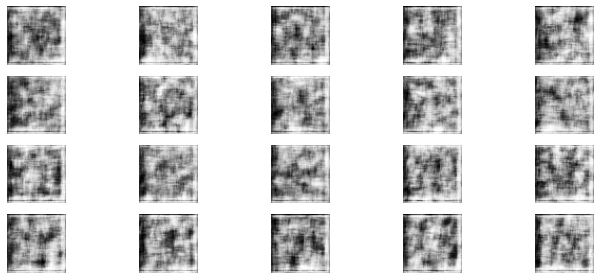

>2, d1=0.605, d2=0.770 g=0.603
>3, d1=0.619, d2=0.769 g=0.628
>4, d1=0.645, d2=0.737 g=0.646
>5, d1=0.643, d2=0.741 g=0.644
>6, d1=0.622, d2=0.749 g=0.637
>7, d1=0.609, d2=0.765 g=0.644
>8, d1=0.636, d2=0.725 g=0.679
>9, d1=0.650, d2=0.706 g=0.684
>10, d1=0.633, d2=0.699 g=0.709
>11, d1=0.642, d2=0.699 g=0.759


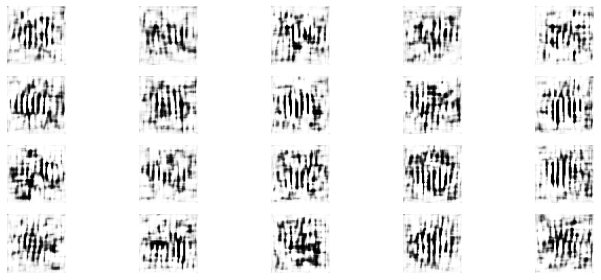

>12, d1=0.606, d2=0.708 g=0.800
>13, d1=0.623, d2=0.666 g=0.828
>14, d1=0.551, d2=0.639 g=0.896
>15, d1=0.560, d2=0.601 g=0.883
>16, d1=0.533, d2=0.738 g=1.110
>17, d1=0.542, d2=0.597 g=1.064
>18, d1=0.498, d2=0.541 g=1.122
>19, d1=0.549, d2=0.735 g=1.393
>20, d1=0.529, d2=0.651 g=1.223
>21, d1=0.553, d2=0.617 g=1.282


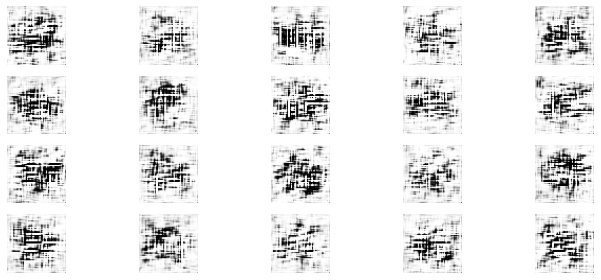

>22, d1=0.527, d2=0.562 g=1.422
>23, d1=0.533, d2=0.663 g=1.296
>24, d1=0.507, d2=0.577 g=1.509
>25, d1=0.512, d2=0.525 g=1.331
>26, d1=0.485, d2=0.676 g=1.426
>27, d1=0.480, d2=0.614 g=1.162
>28, d1=0.470, d2=0.621 g=1.326
>29, d1=0.483, d2=0.585 g=1.421
>30, d1=0.501, d2=0.503 g=1.457
>31, d1=0.494, d2=0.567 g=1.326


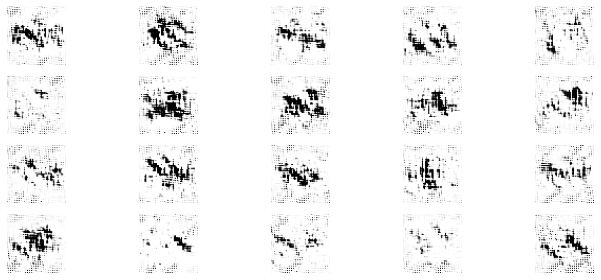

>32, d1=0.445, d2=0.591 g=1.738
>33, d1=0.458, d2=0.585 g=1.771
>34, d1=0.449, d2=0.529 g=1.803
>35, d1=0.413, d2=0.505 g=2.258
>36, d1=0.445, d2=0.600 g=1.941
>37, d1=0.431, d2=0.452 g=2.224
>38, d1=0.410, d2=0.453 g=2.289
>39, d1=0.426, d2=0.477 g=2.050
>40, d1=0.385, d2=0.444 g=2.504
>41, d1=0.351, d2=0.452 g=1.961


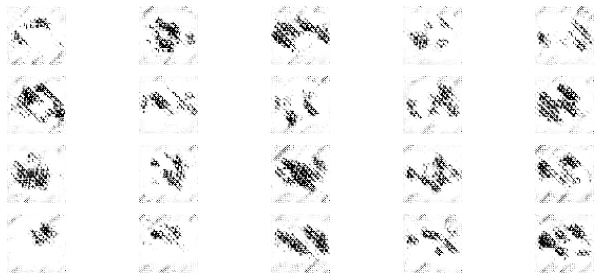

>42, d1=0.359, d2=0.462 g=2.557
>43, d1=0.377, d2=0.427 g=2.327
>44, d1=0.346, d2=0.420 g=2.449
>45, d1=0.348, d2=0.373 g=2.422
>46, d1=0.358, d2=0.404 g=2.641
>47, d1=0.342, d2=0.389 g=2.454
>48, d1=0.340, d2=0.366 g=2.523
>49, d1=0.343, d2=0.396 g=2.150
>50, d1=0.338, d2=0.375 g=2.548
>51, d1=0.351, d2=0.393 g=2.497


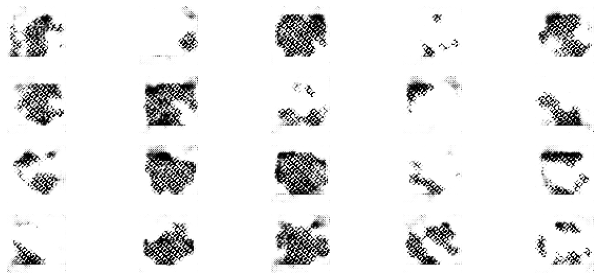

>52, d1=0.349, d2=0.410 g=2.503
>53, d1=0.340, d2=0.400 g=2.449
>54, d1=0.334, d2=0.363 g=2.330
>55, d1=0.335, d2=0.397 g=2.447
>56, d1=0.335, d2=0.397 g=2.299
>57, d1=0.351, d2=0.377 g=2.421
>58, d1=0.339, d2=0.366 g=2.292
>59, d1=0.340, d2=0.377 g=2.239
>60, d1=0.344, d2=0.350 g=2.218
>61, d1=0.345, d2=0.372 g=2.288


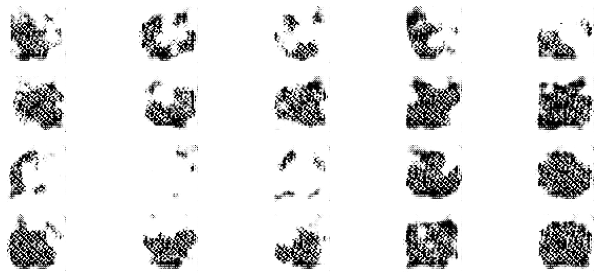

>62, d1=0.342, d2=0.355 g=2.171
>63, d1=0.339, d2=0.379 g=2.201
>64, d1=0.336, d2=0.373 g=2.236
>65, d1=0.336, d2=0.365 g=2.414
>66, d1=0.338, d2=0.370 g=2.389
>67, d1=0.335, d2=0.351 g=2.188
>68, d1=0.334, d2=0.384 g=2.313
>69, d1=0.338, d2=0.350 g=2.166
>70, d1=0.362, d2=0.360 g=2.408
>71, d1=0.338, d2=0.347 g=2.318


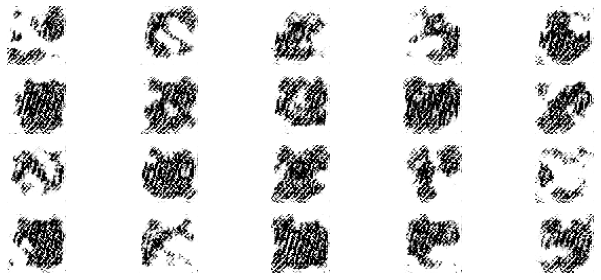

>72, d1=0.339, d2=0.367 g=2.380
>73, d1=0.337, d2=0.362 g=2.509
>74, d1=0.336, d2=0.354 g=2.378
>75, d1=0.346, d2=0.367 g=2.405
>76, d1=0.334, d2=0.348 g=2.455
>77, d1=0.338, d2=0.354 g=2.269
>78, d1=0.337, d2=0.344 g=2.157
>79, d1=0.342, d2=0.351 g=2.434
>80, d1=0.341, d2=0.332 g=2.342
>81, d1=0.349, d2=0.359 g=2.236


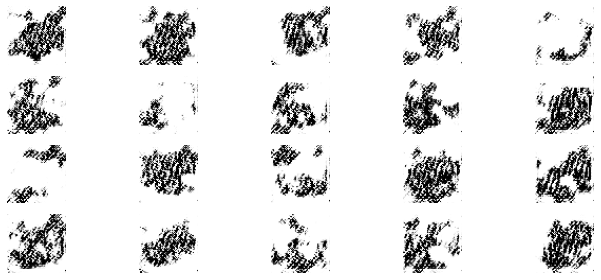

>82, d1=0.344, d2=0.354 g=2.320
>83, d1=0.334, d2=0.353 g=2.286
>84, d1=0.351, d2=0.349 g=2.275
>85, d1=0.340, d2=0.334 g=2.185
>86, d1=0.340, d2=0.360 g=2.350
>87, d1=0.339, d2=0.344 g=2.350
>88, d1=0.331, d2=0.334 g=2.363
>89, d1=0.348, d2=0.335 g=2.300
>90, d1=0.339, d2=0.339 g=2.239
>91, d1=0.343, d2=0.340 g=2.257


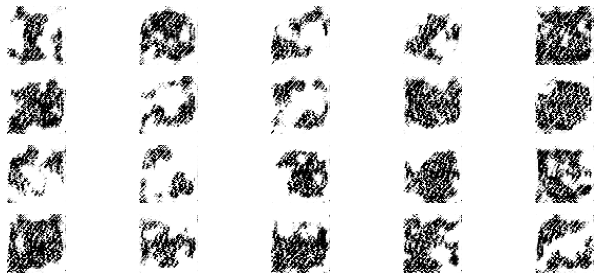

>92, d1=0.341, d2=0.333 g=2.291
>93, d1=0.333, d2=0.338 g=2.291
>94, d1=0.349, d2=0.362 g=2.177
>95, d1=0.337, d2=0.343 g=2.246
>96, d1=0.334, d2=0.340 g=2.206
>97, d1=0.340, d2=0.339 g=2.321
>98, d1=0.337, d2=0.344 g=2.301
>99, d1=0.334, d2=0.344 g=2.240
>100, d1=0.354, d2=0.334 g=2.076
INFO:tensorflow:Assets written to: /content/drive/MyDrive/CC/Models/shape_model3/assets


In [ ]:
# Define the standalone discriminator model
def define_discriminator(in_shape=(image_size,image_size,1)):
  # Label input
  in_label = layers.Input(shape=(num_audio_features,))
  # Scale up to image dimensions with linear activation
  n_nodes = in_shape[0] * in_shape[1]
  li = layers.Dense(n_nodes)(in_label)
  # Reshape to additional channel
  li = layers.Reshape((in_shape[0], in_shape[1], 1))(li)
  # Image input
  in_image = layers.Input(shape=in_shape)
  # Concatenate label as a channel
  merge = layers.Concatenate()([in_image, li])
  # Downsample
  fe = layers.Conv2D(32, (3,3), strides=(2,2), padding='same')(merge)
  fe = layers.Dropout(0.2)(fe)
  fe = layers.LeakyReLU(alpha=0.2)(fe)
  # Downsample
  fe = layers.Conv2D(64, (3,3), strides=(2,2), padding='same')(fe)
  fe = layers.Dropout(0.2)(fe)
  fe = layers.LeakyReLU(alpha=0.2)(fe)
  # Downsample
  fe = layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
  fe = layers.Dropout(0.2)(fe)
  fe = layers.LeakyReLU(alpha=0.2)(fe)
  # Flatten feature maps
  fe = layers.Flatten()(fe)
  # Dropout
  fe = layers.Dropout(0.4)(fe)
  # Output
  out_layer = layers.Dense(1, activation='sigmoid')(fe)
  # Define model
  model = keras.Model([in_image, in_label], out_layer)
  # Compile model
  opt = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

# Define the standalone generator model
def define_generator(latent_dim):
  # Label input
  in_label = layers.Input(shape=(num_audio_features,))
  # Linear multiplication
  n_nodes = 7 * 7
  li = layers.Dense(n_nodes)(in_label)
  # Eeshape to additional channel
  li = layers.Reshape((7, 7, 1))(li)
  # Image generator input
  in_lat = layers.Input(shape=(latent_dim,))
  # Foundation for 7x7 image
  n_nodes = 128 * 7 * 7
  gen = layers.Dense(n_nodes)(in_lat)
  gen = layers.BatchNormalization(momentum=0.9)(gen)
  gen = layers.LeakyReLU(alpha=0.2)(gen)
  gen = layers.Reshape((7, 7, 128))(gen)
  # Merge image gen and label input
  merge = layers.Concatenate()([gen, li])
  # Upsample to 14x14
  gen = layers.UpSampling2D()(merge)
  gen = layers.Conv2DTranspose(256, kernel_size=3, strides=1, padding='same')(gen)
  gen = layers.BatchNormalization(momentum=0.9)(gen)
  gen = layers.LeakyReLU(alpha=0.2)(gen)
  # Upsample to 28x28
  gen = layers.UpSampling2D()(gen)
  gen = layers.Conv2DTranspose(128, kernel_size=3, strides=1, padding='same')(gen)
  gen = layers.BatchNormalization(momentum=0.9)(gen)
  gen = layers.LeakyReLU(alpha=0.2)(gen)
  # Upsample to 56x56
  gen = layers.UpSampling2D()(gen)
  gen = layers.Conv2DTranspose(64, kernel_size=3, strides=1, padding='same')(gen)
  gen = layers.BatchNormalization(momentum=0.9)(gen)
  gen = layers.LeakyReLU(alpha=0.2)(gen)
  # Output
  out_layer = layers.Conv2D(1, kernel_size=5, activation='sigmoid', padding='same')(gen)
  # Define model
  model = keras.Model([in_lat, in_label], out_layer)
  return model

# Define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# Make weights in the discriminator not trainable
	d_model.trainable = False
	# Get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input
	# Get image output from the generator model
	gen_output = g_model.output
	# Connect image output and label input from generator as inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# Define gan model as taking noise and label and outputting a classification
	model = keras.Model([gen_noise, gen_label], gan_output)
	# Compile model
	opt = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# Select real samples
def generate_real_samples(dataset, n_samples):
  # Split into images and labels
  images, labels = dataset
  # Choose random instances
  ix = np.random.randint(0, images.shape[0], n_samples)
  # Select images and labels
  X, labels = images[ix], labels[ix]
  # Generate class labels
  # Label smoothing - use a value of 0.9 instead of 1 to avoid overconfidence!
  y = np.full((n_samples, 1), 0.9)
  return [X, labels], y

# Generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
  # Generate points in the latent space
  x_input = np.random.randn(latent_dim * n_samples)
  # Reshape into a batch of inputs for the network
  z_input = x_input.reshape(n_samples, latent_dim)
  # Generate labels
  labels = (np.random.rand(n_samples, num_audio_features)*2)-1
  return [z_input, labels]

# Use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
  # Generate points in latent space
  z_input, labels_input = generate_latent_points(latent_dim, n_samples)
  # Predict outputs
  images = generator.predict([z_input, labels_input])
  # Create class labels
  # Label smoothing - use a value of 0.1 instead of 0 to avoid overconfidence!
  y = np.full((n_samples, 1), 0.1)
  return [images, labels_input], y

# Train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=64):
  bat_per_epo = int(dataset[0].shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # Manually enumerate epochs
  for i in range(n_epochs):
    # Enumerate batches over the training set
    for j in range(bat_per_epo):
      # Get randomly selected 'real' samples
      [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
      # Update discriminator model weights
      d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
      # Generate 'fake' examples
      [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # Update discriminator model weights
      d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
      # Prepare points in latent space as input for the generator
      [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
      # Create inverted labels for the fake samples
      y_gan = np.ones((n_batch, 1))
      # Update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
    # Summarise loss on this epoch
    print('>%d, d1=%.3f, d2=%.3f g=%.3f' %
      (i+1, d_loss1, d_loss2, g_loss))

    # Every 10 epoch, show some example generations
    if (i%10) == 0:  
      # Generate latent vectors
      noise = np.random.randn(20, latent_dim)
      # Generating an image for each of the 20 sounds in the dataset
      feature_selection = []
      for id in sound_features:
        feature_selection.append(sound_features[id])
      # All generated images as a single array
      gen_imgs = g_model.predict([noise, np.array(feature_selection)])
      # Iterate through each image and plot it as a subplot
      plt.figure(figsize=(10, 4))
      for k in range(gen_imgs.shape[0]):
          plt.subplot(4, 5, k+1)
          plt.imshow(gen_imgs[k, :, :, 0], cmap='gray')
          plt.axis('off')
      plt.tight_layout()
      plt.show()

# Size of the latent space
latent_dim = 128
# Create the discriminator
d_model = define_discriminator()
# Create the generator
g_model = define_generator(latent_dim)
# Create the GAN
gan_model = define_gan(g_model, d_model)
# Train model
train(g_model, d_model, gan_model, dataset, latent_dim)
# Save the trained model
g_model.save(shapes_model_loc)

Here is your visual representation of the timbre!



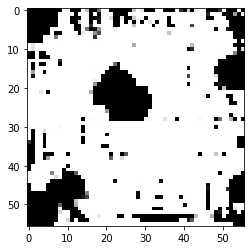

In [ ]:
#@markdown Exploring the conditional space of the GAN - adjust the parameters to your liking and then run the cell to see the result!

hardness = 57 #@param {type:"slider", min:0, max:100, step:1}
depth = 29 #@param {type:"slider", min:0, max:100, step:1}
brightness = 30 #@param {type:"slider", min:0, max:100, step:1}
roughness = 59 #@param {type:"slider", min:0, max:100, step:1}
warmth = 69 #@param {type:"slider", min:0, max:100, step:1}
sharpness = 20 #@param {type:"slider", min:0, max:100, step:1}
booming = 10 #@param {type:"slider", min:0, max:100, step:1}

# Store timbre vector as a np array
timbre_values = [hardness, depth, brightness, roughness, warmth, sharpness, booming]
timbre_values = np.array(timbre_values)
# Generate latent vector and concatenate to timbre vector
random_latent_vector = np.random.randn(128)
gan_input = [np.reshape(random_latent_vector, (1, 128)), np.reshape(timbre_values, (1, num_audio_features))]
# Generate image
image = g_model.predict(gan_input)

print("Here is your visual representation of the timbre!\n")

# Plot image
plt.figure()
plt.imshow(image[0, :, :, 0], cmap='Greys')

### Colour CNN

In [ ]:
# Dictionary to hold the spectrograms for all sgements
spectrograms = {}

# Instantiate loading bar
print("Importing audio files...")
f = IntProgress(min=1, max=200)
display(f) # Display the bar

# Iterating through each audio file in the dataset
for audio_file in os.scandir(moodo_audio_loc):
  # Import audio signal
  y, Fs = import_audio(audio_file.path)
  # Apply HPSS to get the percussive and harmonic components
  y_harm, y_perc = effects.hpss(y)
  # ID of the song is the key for dictionary 'spectrograms'
  number = audio_file.name.split('.')[0]
  # At each key is a list which will hold the sepctrograms for each segment in the audio
  # Put empty list at key of the given song ID, to be filled with spectrograms
  spectrograms[number] = []
  
  segment_size = 3*Fs # Segment size is 3 seconds
  start_sample = 0 #Start taking segments at start of audio file
  # Iterate through the audio file, taking as many 3-second segments as possilbe before reaching the end
  while start_sample < len(y)-segment_size:
    #Take spectrogram of harmonic/percussive segments separately, then combine into a 2-channel image
    harm_spectrum = signal_to_spectrogram(y_harm[start_sample:start_sample+segment_size], Fs)
    perc_spectrum = signal_to_spectrogram(y_perc[start_sample:start_sample+segment_size], Fs)
    combined_spectrum = np.stack((harm_spectrum, perc_spectrum), axis=2)
    # Append to list at the key of the song ID
    spectrograms[number].append(combined_spectrum)
    # Iterate to the next segment in the audio
    start_sample += segment_size
  # Update loading bar value
  f.value = len(spectrograms)

file 1/200 imported
file 2/200 imported
file 3/200 imported
file 4/200 imported
file 5/200 imported
file 6/200 imported
file 7/200 imported
file 8/200 imported
file 9/200 imported
file 10/200 imported
file 11/200 imported
file 12/200 imported
file 13/200 imported
file 14/200 imported
file 15/200 imported
file 16/200 imported
file 17/200 imported
file 18/200 imported
file 19/200 imported
file 20/200 imported
file 21/200 imported
file 22/200 imported
file 23/200 imported
file 24/200 imported
file 25/200 imported
file 26/200 imported
file 27/200 imported
file 28/200 imported
file 29/200 imported
file 30/200 imported
file 31/200 imported
file 32/200 imported
file 33/200 imported
file 34/200 imported
file 35/200 imported
file 36/200 imported
file 37/200 imported
file 38/200 imported
file 39/200 imported
file 40/200 imported
file 41/200 imported
file 42/200 imported
file 43/200 imported
file 44/200 imported
file 45/200 imported
file 46/200 imported
file 47/200 imported
file 48/200 imported
f

In [ ]:
# Import XML file
tree = ET.parse(moodo_xml_loc)
root = tree.getroot()

# Dictionary to hold the average colour value for each song ID
song_colours = {}

# Extracting HSV values from each song for each participant ('user') and converting to RGB
# Iterating through each participant and then their rating for each song nested inside that
for user in root:
  for song in user[15]:
    # Take HSV values from the data
    number = song[0].text
    H, S, V = float(song[3][0].text), float(song[3][1].text), float(song[3][2].text)
    # Convert to RGB values
    R, G, B = colorsys.hsv_to_rgb(H, S, V)
    # If the song ID ('number') already has a list, append the new set of RGb values to the list
    if number in song_colours:
      song_colours[number].append([R, G, B])
    # If not, create a new lsit at that key to hold the RGB values
    else:
      song_colours[number] = [[R, G, B]]

# Taking average of RGB values for each song ID, as mean of each song's np array
for number in song_colours:
  values = np.array(song_colours[number])
  avg = np.mean(values, axis=0)
  song_colours[number] = avg
# song_colours now holds one set of RGB values for each song ID (key)

In [ ]:
# Lists to hold the spectrogram and RGB values in the same order, to use at the dataset
images = []
labels = []

# Iterate through each key (song ID) in the list above,
# and append the image (spectrogram) and label (RGB values) for each
for song_no in spectrograms:
  for segment in spectrograms[song_no]:
    images.append(segment)
    labels.append(song_colours[song_no])

# Convert data to np array
images = np.array(images)
labels = np.array(labels)

# Create list of all indices in dataset, then shuiffle randomly so segments
# from the same song don't get clustered together
indices = list(range(len(images)))
random.shuffle(indices)
# Set a 'cutoff' index wich defines the point between training and validation set - at 90% of total dataset size
cutoff = int(images.shape[0]*0.9)

# create empty lists to append training and test data separately
train_labels = []
train_images = []
test_labels = []
test_images = []
# iterate through each index, append 90% to training and 10% to test
for i in range(len(indices)):
  index = indices[i]
  if i < cutoff:
    train_labels.append(labels[index])
    train_images.append(images[index])
  else:
    test_labels.append(labels[index])
    test_images.append(images[index])

# Take shape of spectrograms (3D)
images_shape = images[0].shape

# convert all datasets to np arrays
train_labels = np.array(train_labels)
train_images = np.array(train_images)
test_labels = np.array(test_labels)
test_images = np.array(test_images)

(894, 192, 130, 2)
(100, 192, 130, 2)
(894, 3)
(100, 3)


example 1


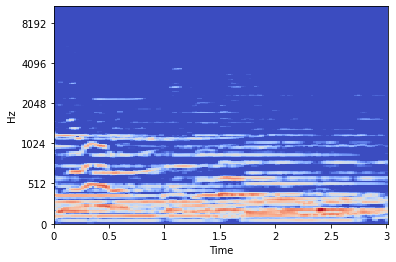

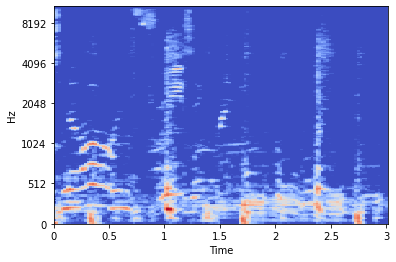

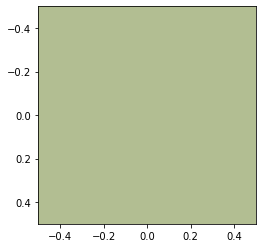

example 2


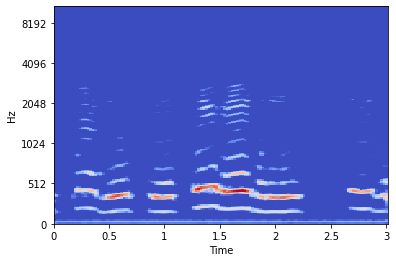

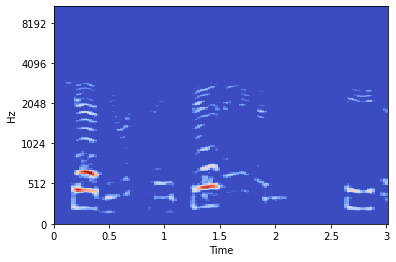

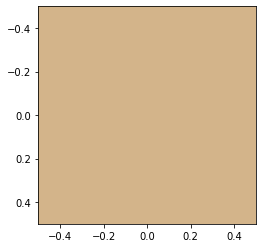

example 3


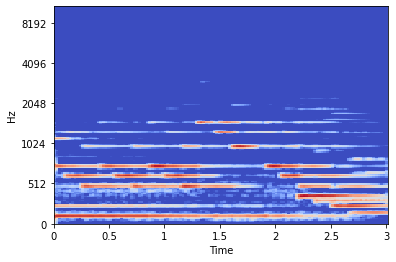

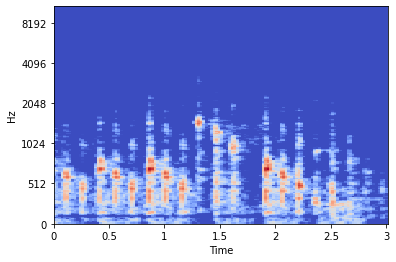

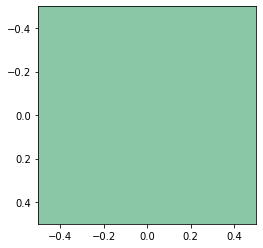

example 4


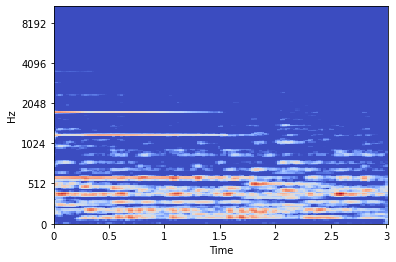

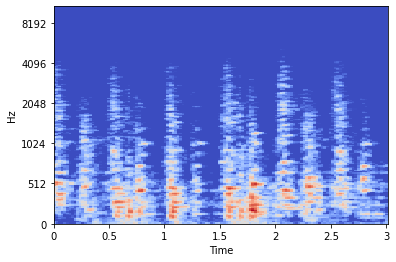

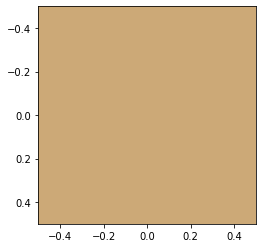

example 5


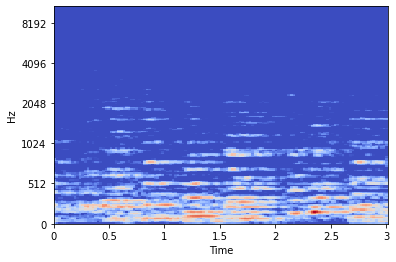

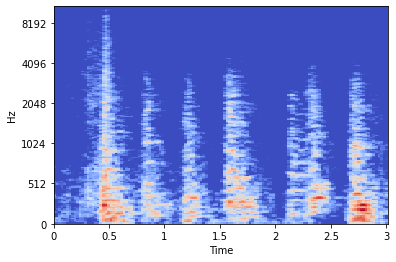

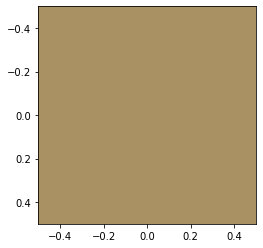

example 6


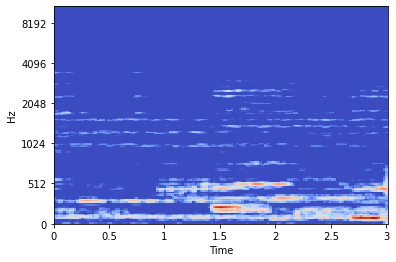

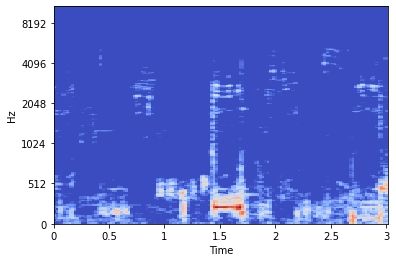

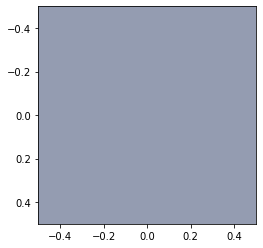

example 7


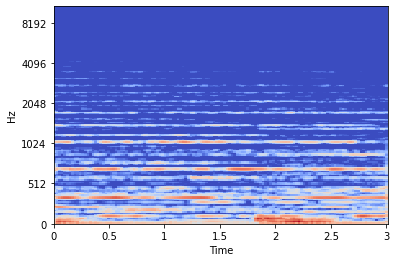

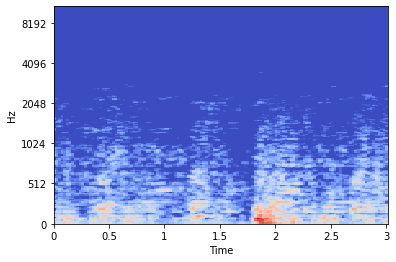

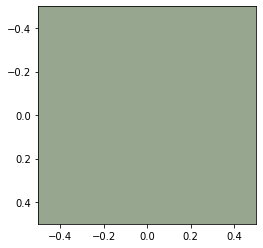

example 8


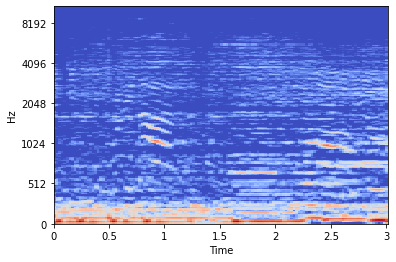

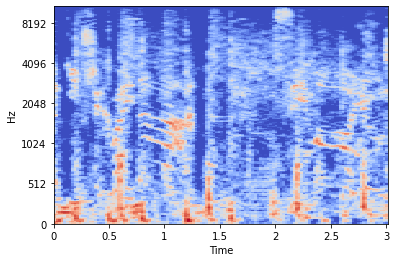

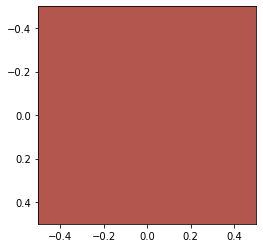

example 9


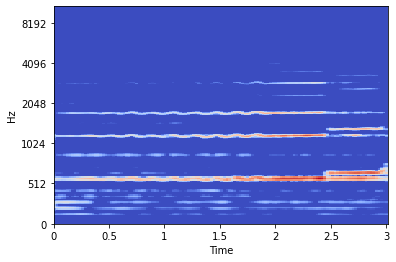

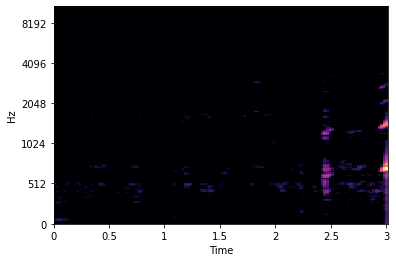

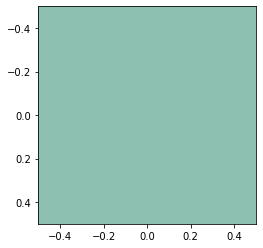

example 10


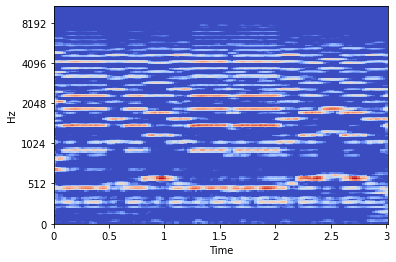

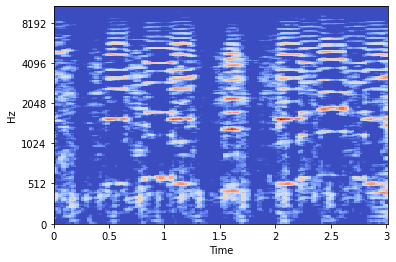

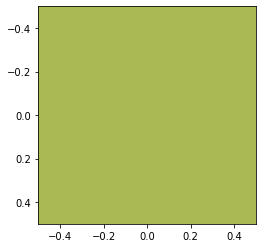

([], <a list of 0 Text major ticklabel objects>)

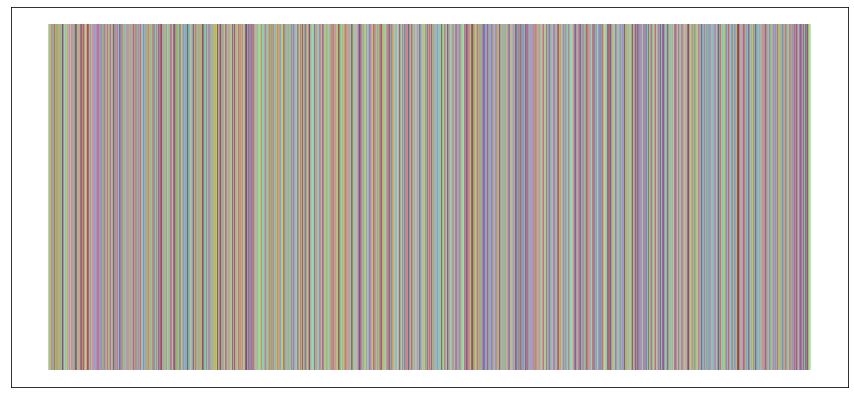

In [ ]:
# Show examples of dataset

# Plot first 10 spectrograms in training data along with the RGB colours
for i in range(10):
  print("Example {}".format(i+1))
  rgb = train_labels[i]
  # Harmonic component
  plt.figure()
  display.specshow(train_images[i,:,:,0], sr=Fs, y_axis='mel', x_axis='time')
  # Percussive component
  plt.figure()
  display.specshow(train_images[i,:,:,1], sr=Fs, y_axis='mel', x_axis='time')
  # RGB colour
  plt.figure()
  plt.imshow([[(rgb)]])
  plt.show()

# Plot all average RGB values in the training data
plt.figure(figsize=(15, 7))
plt.vlines(np.arange(len(train_labels)), 0, 1, train_labels)
plt.yticks([])
plt.xticks([])

In [ ]:
# Building the CNN model

CNNmodel = models.Sequential()
# First convolution layer
CNNmodel.add(layers.Conv2D(32, kernel_size=3, activation='relu', input_shape=images_shape))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
CNNmodel.add(layers.BatchNormalization())
# Second convolution layer
CNNmodel.add(layers.Conv2D(64, kernel_size=3, activation='relu'))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
CNNmodel.add(layers.BatchNormalization())
# Third convolution layer
CNNmodel.add(layers.Conv2D(128, kernel_size=3, activation='relu'))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
CNNmodel.add(layers.BatchNormalization())
# Fourth convolution layer
CNNmodel.add(layers.Conv2D(256, kernel_size=3, activation='relu'))
CNNmodel.add(layers.Flatten())
# First dense layer
CNNmodel.add(layers.Dense(512, activation='relu'))
CNNmodel.add(layers.Dropout(0.2))
# Second dense layer
CNNmodel.add(layers.Dense(256, activation='relu'))
CNNmodel.add(layers.Dropout(0.2))
# Third dense layer
CNNmodel.add(layers.Dense(128, activation='relu'))
# Output layer
CNNmodel.add(layers.Dense(3, activation='sigmoid')) #3 outputs: R, G, B
CNNmodel.summary()

# Compile model
CNNmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mean_absolute_error'])

# Train model
history = CNNmodel.fit(train_images, train_labels, epochs=50, batch_size=16,
                    validation_data=(test_images, test_labels))

# Save the trained model
CNNmodel.save(colour_model_loc)

NameError: ignored

### Image Processing

In [22]:
#@markdown Please select a track to be visualised!

track_chosen = "trance.mp3" #@param ["next_version.wav", "minimal_techno.wav", "downtempo.mp3", "trance.mp3", "dopplereffekt.wav"]
audio_path = audio_loc + track_chosen

framing = True #@param {type:"boolean"}

In [23]:
# General functions to be used

def segment_audio(times, y):
  """
  Function to segment a given audio file according to a set of time points.

  Arguments:
  times - list of time points, in samples
  y - the signal array to be segmented

  Returns:
  segments - a list of audio signals segmented from the original
             audio signal, according to the time points
  start_end - a list of start time/end time pairs, all in samples
  """
  # Empty lists to hold the returned data
  segments = []
  start_end = []
  
  # Start time to use for segmentation
  start = 0
  # Iterate through each time point
  for time in times:
    end = time - 1 # Segment the area prior to the given time point
    start_end.append([start, end]) # Append start and end times as a pair
    start = time # Make the start time for the next iteration the end time of this iteration
  start_end.append([start, len(y)-1])
  # Take segment using the start/end time pairs
  for pair in start_end:
    segments.append(y[pair[0]:pair[1]])
  # Return both as lists
  return segments, start_end

def moving_average(signal, window_size):
  """
  Function to apply a moving average filter to a signal.
  
  Arguments:
  signal - signal to be filtered
  window_size - window size of the moving average calculation

  Returns:
  filtered_signal - the filtered signal
  """

  # Zero paddding the signal accoridng to window size
  padded_signal = np.concatenate([np.zeros(window_size//2), signal, np.zeros(window_size//2)])
  # Filtering by convolving with the window
  filtered_signal = np.convolve(padded_signal, np.ones(window_size), 'valid')/window_size
  # Normalise to range [0, 1]
  filtered_signal = (filtered_signal-np.min(filtered_signal))/(np.max(filtered_signal)-np.min(filtered_signal))
  return filtered_signal

In [24]:
# Loading audio file and sampling frequency
y, Fs = import_audio(audio_path)
# Apply HPSS to get harmonic and percussive components
y_harm, y_perc = effects.hpss(y)

# If framing is active, display the audio and its components as playable widgets
if framing:
  ipd.display(ipd.HTML(data='<html><body><h3>Original audio:</h3></body></html>'))
  ipd.display(ipd.Audio(y, rate=Fs))
  ipd.display(ipd.HTML(data='<html><body><h3>Extracted harmonic component:</h3></body></html>'))
  ipd.display(ipd.Audio(y_harm, rate=Fs))
  ipd.display(ipd.HTML(data='<html><body><h3>Extracted percussive component:</h3></body></html>'))
  ipd.display(ipd.Audio(y_perc, rate=Fs))

# Calculate normalised amp envelope using moving average filter with a 0.1s window size
amplitude_envelope = moving_average(np.abs(y),int(0.1 * Fs))

# Finding spectral centroid at each frame of the audio spectrogram
centroid_values = librosa.feature.spectral_centroid(y)[0]
# Find the corresponding times (in samples) of each frame in the spectrogram
centroid_times = librosa.frames_to_samples(np.arange(len(centroid_values)), hop_length=512)
# Interpolate centroid value between each frame time in the original signal
centroid_envelope = np.interp(np.arange(len(y)), np.array(centroid_times), centroid_values)
# Calculate normalised spectral centroid envelope using moving average filter with a 0.1s window size
centroid_envelope = moving_average(centroid_envelope, int(0.1 * Fs))

# Extract beat times from audio
tempo, beat_times = beat.beat_track(y, Fs, hop_length=512, units='samples')
# Total number of detected beats
number_of_beats = len(beat_times)

Output hidden; open in https://colab.research.google.com to view.

In [25]:
# Extracting colours - RGB value for each sample in the track

# Take 3-second segment around each beat time
beat_segments = []
for time in beat_times:
  segment_size = 3*Fs # 3 seconds in samples
  either_side = segment_size//2 # Segment size either side of the beat
  # If segment goes outside of the size of the audio signal, just take it from the start/end
  # (taking segments of both the harmonic component and the percussive component)
  if time <= either_side:
    segment_harm = y_harm[0:segment_size]
    segment_perc = y_perc[0:segment_size]
  elif time + either_side >= len(y):
    segment_harm = y_harm[-segment_size:-1]
    segment_perc = y_perc[-segment_size:-1]
  # Otherwise, just take the segment centred around the beat time
  else:
    segment_harm = y_harm[time-either_side:time+either_side]
    segment_perc = y_perc[time-either_side:time+either_side]
  # Take spectrograms of the harmonic and percussive segments
  spectrogram_harm = signal_to_spectrogram(segment_harm, Fs)
  spectrogram_perc = signal_to_spectrogram(segment_perc, Fs)
  # Combine the two spectrograms as two channels of a single image,
  # and append the results the beat_segments list
  beat_segments.append(np.stack((spectrogram_harm, spectrogram_perc), axis=2))

# Load CNN colour model
colour_model = keras.models.load_model(colour_model_loc)

# Create np array to store the RGB values for each beat
beat_colours = np.empty((number_of_beats, 3))
# Find colour for each beat segment, by passing it through the model, and save into array
for beat_no in range(number_of_beats):
  spectral_image = np.expand_dims(beat_segments[beat_no], axis=0) 
  beat_colours[beat_no] = colour_model.predict(spectral_image)[0]

# Create array to store the RGB values for every sample point in the track
sample_colours = np.empty((len(y), 3))
# Calculate values at every sample by interpolating the RGB values at each beat time
sample_colours[:,0] = np.interp(np.arange(len(y)), np.array(beat_times), beat_colours[:,0]) # R
sample_colours[:,1] = np.interp(np.arange(len(y)), np.array(beat_times), beat_colours[:,1]) # G
sample_colours[:,2] = np.interp(np.arange(len(y)), np.array(beat_times), beat_colours[:,2]) # B

In [26]:
# Extracting shapes - image for each onset segment in the track

# Extract onset times, in samples
onset_times = onset.onset_detect(y, Fs, hop_length=512, units='samples')

# Use segment_audio function to segment according to the onset times
onset_segments, onset_start_end = segment_audio(onset_times, y)
no_of_onset_segments = len(onset_segments)

# Instantiate loading bar
print("Extracting timbre features for each onset...")
f = IntProgress(min=1, max=no_of_onset_segments)
display(f) # Display the loading bar

# Iterate through the onset segments, extracting the timbre vector
# of each and saving it into the onset_timbres array
segment_no = 0 # Use this as the index when saving into the array
onset_timbres = np.empty((no_of_onset_segments, num_audio_features)) # Empty array
for segment in onset_segments:
  # Normalise volume of each segment prior to extracting timbre
  segment = segment / np.max(np.abs(segment))
  # Extract timbre vector and save it
  onset_timbres[segment_no] = get_timbre_vector(segment, Fs)
  segment_no += 1
  f.value = segment_no # Update loading bar value

# Load the shapes GAN to generate new images
shapes_model = keras.models.load_model(shapes_model_loc)

# Instantiate loading bar
print("Generating shape for each onset...")
f = IntProgress(min=1, max=no_of_onset_segments)
display(f) # Display the loading bar

# Generate the shape for each onset segment
shapes_array = [] # Array to hold the generated images
# Iterate through each segment
# Time of the previous onset, in samples (initialise as 0)
prev_onset_start = 0
# Time of the 'next' beat form the onset, in samples (initialise as -1)
next_beat = -1
# 'Tolerance' of 50ms for whether a new beat has occured with the onset (for cases where an onset lies on the beat)
tolerance = Fs/20

for segment_no in range(no_of_onset_segments):
  start_time = onset_start_end[segment_no][0]
  # Each time the beat changes from one onset to the next, the latent vector changes
  if start_time > next_beat: # If start time of onset exceeds the 'next' beat from the last iteration
    random_latent_vector = np.reshape(np.random.randn(128), (1, 128)) # Generate new latent vector
    # Finding the 'next' beat time to the onset, as the closest value with a positive difference (plus the 'tolerance')
    difference = np.array(beat_times) - start_time # All beat times subtracted by onset start time to find the difference
    if np.max(difference) > -tolerance: # Check that there are some 'next' beats to come still
      # Update with the next beat found immediately after the onset start
      next_beat = np.min(difference[difference > -tolerance]) + start_time
  # Concatenate the latent vector and the timbre vector from the current segment
  gan_input = [random_latent_vector, np.reshape(onset_timbres[segment_no], (1, num_audio_features))]
  # Convert generated image to standard grayscale format 
  shape = np.array(shapes_model(gan_input))*255
  shape = shape[0, :, :, 0].astype(np.uint8)
  shapes_array.append(shape) # Append image to array
  f.value = segment_no + 1 # Update loading bar value

Extracting timbre features for each onset...


IntProgress(value=1, max=948, min=1)

Generating shape for each onset...


IntProgress(value=1, max=948, min=1)

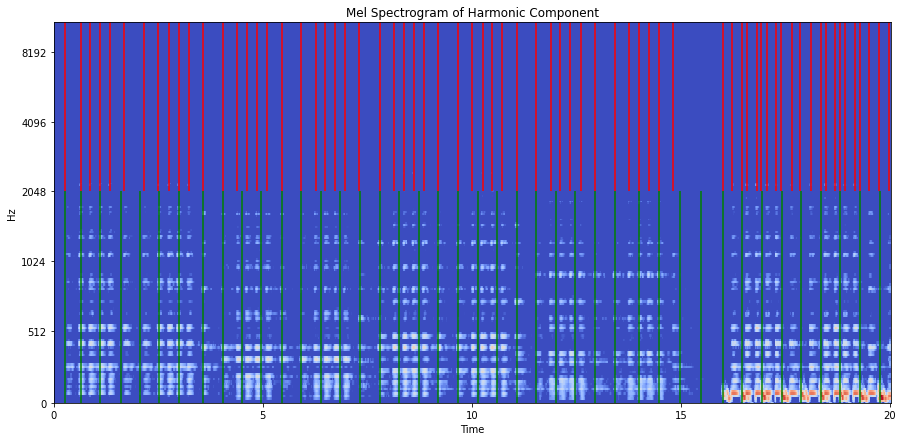

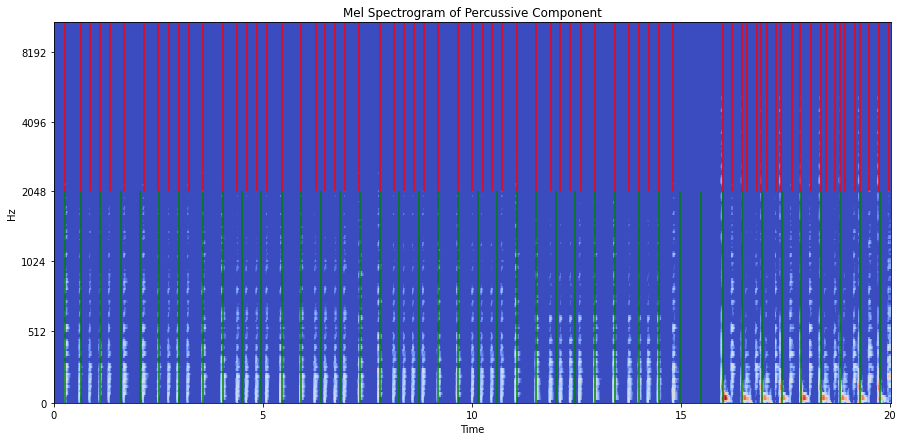

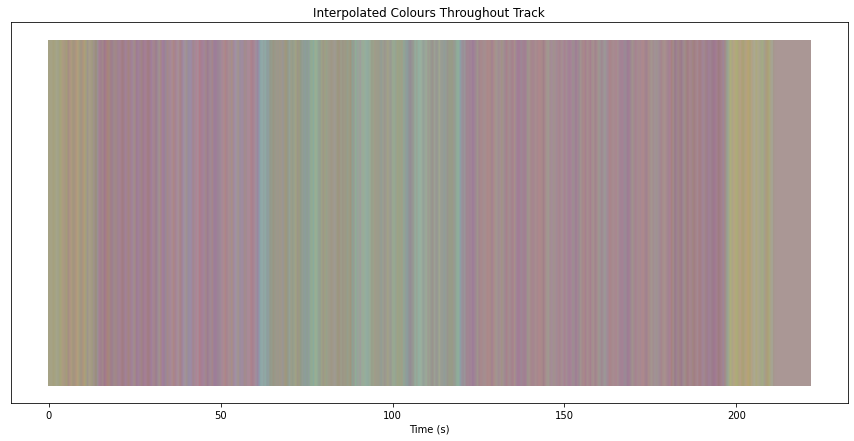

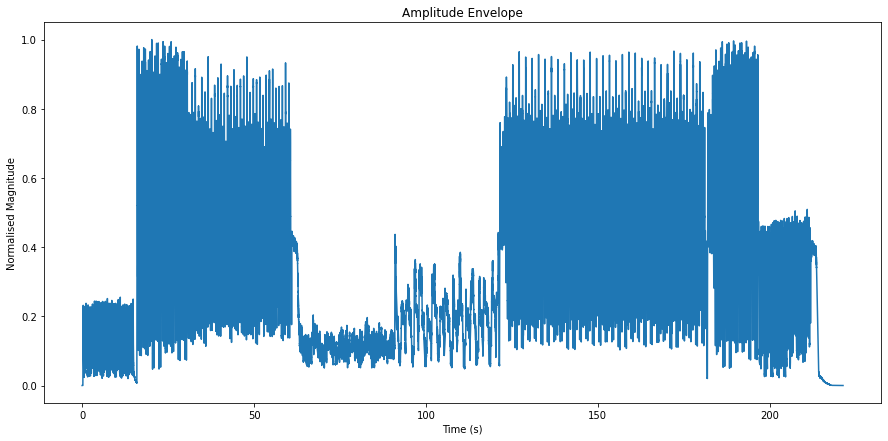

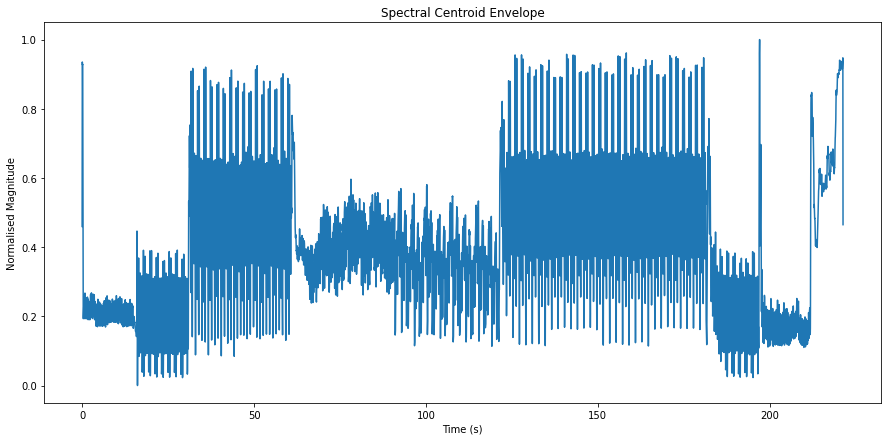

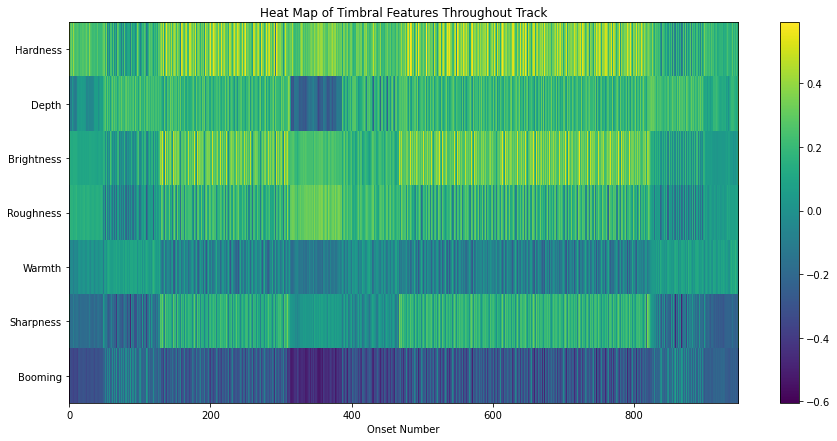

In [27]:
# Framing (optional)

if framing:
  # Plot Mel spectrogram of the harmonic component
  # Also plot the beat/onset times as green/red vertical lines
  plt.figure(figsize=(15, 7))
  plt.title('Mel Spectrogram of Harmonic Component')
  # (Just the first 20 seconds, as too much to plot otherwise)
  total_spectrum = signal_to_spectrogram(y_harm[:Fs*20], Fs)
  specshow(total_spectrum, sr=Fs, y_axis='mel', x_axis='time')
  plt.vlines(beat_times/Fs, 0, 2048, color='g', label='Beat Times')
  plt.vlines(onset_times/Fs, 2048, Fs/2, color='r', label='Onset Times')

  # Plot Mel spectrogram of the percussive component
  # Also plot the beat/onset times as green/red vertical lines
  plt.figure(figsize=(15, 7))
  plt.title('Mel Spectrogram of Percussive Component')
  # (Just the first 20 seconds, as too much to plot otherwise)
  total_spectrum = signal_to_spectrogram(y_perc[:Fs*20], Fs)
  specshow(total_spectrum, sr=Fs, y_axis='mel', x_axis='time')
  plt.vlines(beat_times/Fs, 0, 2048, color='g', label='Beat Times')
  plt.vlines(onset_times/Fs, 2048, Fs/2, color='r', label='Onset Times')

  # Plot RGB values for each sample as a single vertical line
  plt.figure(figsize=(15, 7))
  plt.title('Interpolated Colours Throughout Track')
  plt.vlines(np.arange(len(y))/Fs, 0, 1, sample_colours)
  plt.yticks([])
  plt.xlabel('Time (s)')

  # Plot amplitude envelope
  plt.figure(figsize=(15, 7))
  plt.title('Amplitude Envelope')
  plt.plot(np.arange(len(y))/Fs, amplitude_envelope)
  plt.xlabel('Time (s)')
  plt.ylabel('Normalised Magnitude')

  # Plot spectral centroid envelope
  plt.figure(figsize=(15, 7))
  plt.title('Spectral Centroid Envelope')
  plt.plot(np.arange(len(y))/Fs, centroid_envelope)
  plt.xlabel('Time (s)')
  plt.ylabel('Normalised Magnitude')

  # Plot 'heat map' of the timbre vector for each onset in the track
  # x axis is onset number, y axis is timbral features, 'heat' colour is determined by value of the feature
  plt.figure(figsize=(15, 7))
  plt.title('Heat Map of Timbral Features Throughout Track')
  plt.imshow(onset_timbres.T, interpolation='nearest', aspect='auto')
  plt.colorbar()
  timbre_list = ['Hardness', 'Depth', 'Brightness', 'Roughness', 'Warmth', 'Sharpness', 'Booming']
  plt.yticks(range(num_audio_features), labels=timbre_list)
  plt.xlabel('Timbral Quality')
  plt.xlabel('Onset Number')

In [28]:
# Creating images (frames) from the extracted features and compling video from the images

frame_rate = 30 # Frame rate of the video output
output_video_dimensions = (1000, 1000) # Dimensions of the final (upscaled) video output
frame_interval_samples = Fs//frame_rate # Number of audio samples between each frame

 # Extract name of audio file from the path
audio_name = '/'+audio_path.split('/')[-1].split('.')[0]
# Create cv2 object for writing out the mp4 video
out = cv2.VideoWriter(video_path+audio_name+'.mp4', cv2.VideoWriter_fourcc(*'mp4v'), frame_rate, output_video_dimensions)

# Iterate through the audio sample at each video frame in a while loop,
# until the audio sample number exceeds the length of the audio
sample = 0
while sample <= len(y):
  # Extract RGB values in range [0, 1] at the current sample,
  # and create tupple of the values in range [0, 255]
  RGBvalues = sample_colours[sample]
  RGBvalues = tuple([int(x * 255) for x in RGBvalues])
  # Retrieving 'shape' image for the onset segment containing the current sample
  # First, find the correct onset segment number as the segment which encapsulates the current sample time  
  seg = 0 # 'seg' is the segment number for the correct onset segment
  # Iterate through all segments
  for segment_no in range(no_of_onset_segments):
    # If the sample is found between the start and end times of the given segment, we have found the correct onset
    if sample in range(onset_start_end[segment_no][0], onset_start_end[segment_no][1]):
      seg = segment_no
      break
  shape = shapes_array[seg] # Take the generated image for the given onset
  shape_img = Image.fromarray(shape, mode="L") # Convert the image to PIL image format

  # Map spectral centroid to colour of shape (this feature is disabled)
  shape_colour = 0 #int(centroid_envelope[sample]*255)

  # Colourise the shape image with the RGB value at the current sample (replacing the background colour of black)
  shape_img = ImageOps.colorize(shape_img, black = (shape_colour, shape_colour, shape_colour), white = RGBvalues)

  # Blend between background and shape along to amplitude (this feature is also disabled)
  #background_img = Image.new("RGB", (image_size, image_size), RGBvalues)
  #shape_img = Image.blend(shape_img, background_img, 1-(amplitude_envelope[sample]**5))

  # Convert to cv2 format for writing as a video frame
  converted = cv2.cvtColor(np.array(shape_img), cv2.COLOR_RGB2BGR)
  # Upscale to 1000x1000 but not apply antialiasing
  resized = cv2.resize(converted, output_video_dimensions, interpolation=cv2.INTER_NEAREST)

  # Apply dilation/erosion based on value of amp envelope at the current sample
  # High value = dilation (bigger shape), low value = erosion (smaller shape)
  # The shape therefore 'pumps' along to the music
  kernel = np.ones((5, 5),np.uint8) # Kerel for dilation/erosion
  if amplitude_envelope[sample] > 0.9:
    resized = cv2.dilate(resized,kernel,iterations = 3)
  elif amplitude_envelope[sample] > 0.8:
    resized = cv2.dilate(resized,kernel,iterations = 2)
  if amplitude_envelope[sample] > 0.65:
    resized = cv2.dilate(resized,kernel,iterations = 1)
  elif amplitude_envelope[sample]< 0.35:
    resized = cv2.erode(resized,kernel,iterations = 1)
  elif amplitude_envelope[sample]< 0.2:
    resized = cv2.erode(resized,kernel,iterations = 2)
  elif amplitude_envelope[sample]< 0.1:
    resized = cv2.erode(resized,kernel,iterations = 3)
  
  # Write the final image as a frame in the video
  out.write(resized)
  # Incement the current sample number by the interval between each frame in samples
  sample += frame_interval_samples
  # Uncomment the line below to show each frame of the video as an individual image
  #cv2_imshow(resized)
out.release()

In [29]:
# Combining audio and video using moviepy

# Import the video created in the previous cell
video = mp.VideoFileClip(video_path+audio_name+'.mp4')
# Import the original audio file the video was created from
audio = mp.AudioFileClip(audio_path)
# Add the audio to the video
final = video.set_audio(audio)
# Write the video back out as an mp4 file, with '_with_sound' added to the filename
final.write_videofile(video_path+audio_name+'_with_sound'+'.mp4', audio=True)

# Show the final video and audio inside colab using HTML
video_file = open(video_path+audio_name+'_with_sound'+'.mp4', "r+b").read()
video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
ipd.display(ipd.HTML("""<video width={400} controls><source src="{video_url}"></video>"""))

[MoviePy] >>>> Building video /content/drive/MyDrive/CC/Outputs/trance_with_sound.mp4
[MoviePy] Writing audio in trance_with_soundTEMP_MPY_wvf_snd.mp3


100%|██████████| 4880/4880 [00:07<00:00, 676.24it/s]

[MoviePy] Done.
[MoviePy] Writing video /content/drive/MyDrive/CC/Outputs/trance_with_sound.mp4



100%|██████████| 6640/6640 [06:22<00:00, 17.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/CC/Outputs/trance_with_sound.mp4 

